In [1]:
from rich import print

In [2]:
import time

import dill as pickle
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

### using Metal or not

In [4]:
# Using GPU makes the training process slower than using CPU
# Since the dataset is small.

using_mps = True
# using_mps = False  

In [9]:
# check if mps is available
# if yes, set default tensor type to mps

if torch.mps.is_available() and using_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f'{device = }')

device = device(type='mps')

### Neural Network Class

In [10]:
class Classifier(nn.Module):

    def __init__(self, inodes, hnodes, onodes, learning_rate):
        # call the base class's initialisation too
        super().__init__()
        
        # dimensions
        self.inodes, self.hnodes, self.onodes = inodes, hnodes, onodes
        
        # learning rate
        self.lr = learning_rate
        
        # define the layers and their sizes, turn off bias
        self.linear_ih = nn.Linear(inodes, hnodes, bias=False)
        self.linear_ho = nn.Linear(hnodes, onodes, bias=False)
        
        # define activation function
        self.activation = nn.Sigmoid()
        # define inverse activation function
        self.inverse_activation_function = torch.logit
        
        # create error function
        # self.error_function = torch.nn.MSELoss(size_average=False)  # size_average is deprecated
        self.error_function = torch.nn.MSELoss(reduction='sum')

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), self.lr)

        # use GPU if it is available
        self.FloatTensor = torch.mps.Tensor if device.type=='mps' else torch.FloatTensor
            
        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        
    
    def forward(self, inputs_list):
        # convert list to a 2-D FloatTensor then wrap in Variable 
        inputs = Variable(self.FloatTensor(inputs_list).view(1, self.inodes))
            
        # combine input layer signals into hidden layer
        hidden_inputs = self.linear_ih(inputs)
        # apply sigmiod activation function
        hidden_outputs = self.activation(hidden_inputs)
        
        # combine hidden layer signals into output layer
        final_inputs = self.linear_ho(hidden_outputs)
        # apply sigmiod activation function
        final_outputs = self.activation(final_inputs)
        
        return final_outputs

    
    def train(self, inputs_list, targets_list, print_counter=False):
        # calculate the output of the network
        output = self.forward(inputs_list)

        # create a Variable out of the target vector, doesn't need gradients calculated
        target_variable = Variable(self.FloatTensor(targets_list).view(1, self.onodes), requires_grad=False)
        
        # calculate error
        loss = self.error_function(output, target_variable)
        
        # increase counter 
        self.counter += 1

        # accumulate error every 10 loops
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        # print counter every 10000 loops
        if print_counter and (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        
    def backquery(self, targets_list):
        """backquery the neural network."""
        def _scale(signal):
            # scale signal to 0.01 to 0.99
            signal -= signal.min().item()
            signal /= signal.max().item()
            signal *= 0.98
            signal += 0.01
            return signal
        
        # create a Variable out of the target vector, doesn't need gradients calculated
        target_variable = Variable(self.FloatTensor(targets_list).view(1, self.onodes), requires_grad=False).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(target_variable)
        # calculate the signal out of the hidden layer and scale them back to 0.01 to 0.99
        hidden_outputs = _scale(torch.matmul(self.linear_ho.weight.T, final_inputs))
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        # calculate the signal out of the input layer and scale them back to 0.01 to .99
        inputs = _scale(torch.matmul(self.linear_ih.weight.T, hidden_inputs))
        
        return inputs
    
    
    def plot_progress(self):
        """Plot classifier error.
        """
        df = pd.DataFrame(self.progress, columns=['loss'])
        plt_kwargs = {
            'figsize':  (16, 8), 
            # 'ylim':  (0, 1.0), 
            'ylim':  (0, max(self.progress)), 
            'alpha':  0.1, 
            'marker':  '.', 
            'grid':  True, 
        }
        df.plot(**plt_kwargs)


    def pickle(self, filename='classifier.pkl'):
        """Pickle and save the trained classifier.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

### create neural network

In [13]:
# number of input, hidden and output nodes
input_nodes, hidden_nodes, output_nodes = 784, 200, 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = Classifier(input_nodes, hidden_nodes, output_nodes, learning_rate)

# move neural network to the GPU
if device.type == 'mps':
    n.mps()

AttributeError: 'Classifier' object has no attribute 'mps'

In [12]:
dir(n)

['FloatTensor',
 'T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persi

### set training epoch

In [7]:
# epochs is the number of times the training data set is used for training

epochs = 10  # best
# epochs = 1

### load the mnist training data CSV file into a list

In [8]:
with open("./mnist_dataset/mnist_train.csv", 'r') as training_data_file:
    training_data_list = training_data_file.readlines()

### train the neural network

In [10]:
%%time

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets, print_counter=True)
        
        # create rotated variations
        # rotated anticlockwise by x degrees
        x = 10
        inputs_plusx_img = scipy.ndimage.rotate(inputs.reshape(28, 28), x, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets, print_counter=True)
        
        # rotated clockwise by x degrees
        inputs_minusx_img = scipy.ndimage.rotate(inputs.reshape(28, 28), -x, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets, print_counter=True)

counter =  20000

counter =  30000

counter =  40000

counter =  50000

counter =  60000

counter =  70000

counter =  80000

counter =  90000

counter =  100000

counter =  110000

counter =  120000

counter =  130000

counter =  140000

counter =  150000

counter =  160000

counter =  170000

counter =  180000

counter =  190000

counter =  200000

counter =  210000

counter =  220000

counter =  230000

counter =  240000

counter =  250000

counter =  260000

counter =  270000

counter =  280000

counter =  290000

counter =  300000

counter =  310000

counter =  320000

counter =  330000

counter =  340000

counter =  350000

counter =  360000

counter =  370000

counter =  380000

counter =  390000

counter =  400000

counter =  410000

counter =  420000

counter =  430000

counter =  440000

counter =  450000

counter =  460000

counter =  470000

counter =  480000

counter =  490000

counter =  500000

counter =  510000

counter =  520000

counter =  530000

counter =  540000

counter =  550000

counter =  560000

counter =  570000

counter =  580000

counter =  590000

counter =  600000

counter =  610000

counter =  620000

counter =  630000

counter =  640000

counter =  650000

counter =  660000

counter =  670000

counter =  680000

counter =  690000

counter =  700000

counter =  710000

counter =  720000

counter =  730000

counter =  740000

counter =  750000

counter =  760000

counter =  770000

counter =  780000

counter =  790000

counter =  800000

counter =  810000

counter =  820000

counter =  830000

counter =  840000

counter =  850000

counter =  860000

counter =  870000

counter =  880000

counter =  890000

counter =  900000

counter =  910000

counter =  920000

counter =  930000

counter =  940000

counter =  950000

counter =  960000

counter =  970000

counter =  980000

counter =  990000

counter =  1000000

counter =  1010000

counter =  1020000

counter =  1030000

counter =  1040000

counter =  1050000

counter =  1060000

counter =  1070000

counter =  1080000

counter =  1090000

counter =  1100000

counter =  1110000

counter =  1120000

counter =  1130000

counter =  1140000

counter =  1150000

counter =  1160000

counter =  1170000

counter =  1180000

counter =  1190000

counter =  1200000

counter =  1210000

counter =  1220000

counter =  1230000

counter =  1240000

counter =  1250000

counter =  1260000

counter =  1270000

counter =  1280000

counter =  1290000

counter =  1300000

counter =  1310000

counter =  1320000

counter =  1330000

counter =  1340000

counter =  1350000

counter =  1360000

counter =  1370000

counter =  1380000

counter =  1390000

counter =  1400000

counter =  1410000

counter =  1420000

counter =  1430000

counter =  1440000

counter =  1450000

counter =  1460000

counter =  1470000

counter =  1480000

counter =  1490000

counter =  1500000

counter =  1510000

counter =  1520000

counter =  1530000

counter =  1540000

counter =  1550000

counter =  1560000

counter =  1570000

counter =  1580000

counter =  1590000

counter =  1600000

counter =  1610000

counter =  1620000

counter =  1630000

counter =  1640000

counter =  1650000

counter =  1660000

counter =  1670000

counter =  1680000

counter =  1690000

counter =  1700000

counter =  1710000

counter =  1720000

counter =  1730000

counter =  1740000

counter =  1750000

counter =  1760000

counter =  1770000

counter =  1780000

counter =  1790000

counter =  1800000

counter =  1810000

CPU times: user 7min 34s, sys: 1min 1s, total: 8min 35s
Wall time: 7min 35s


### plot classifier error

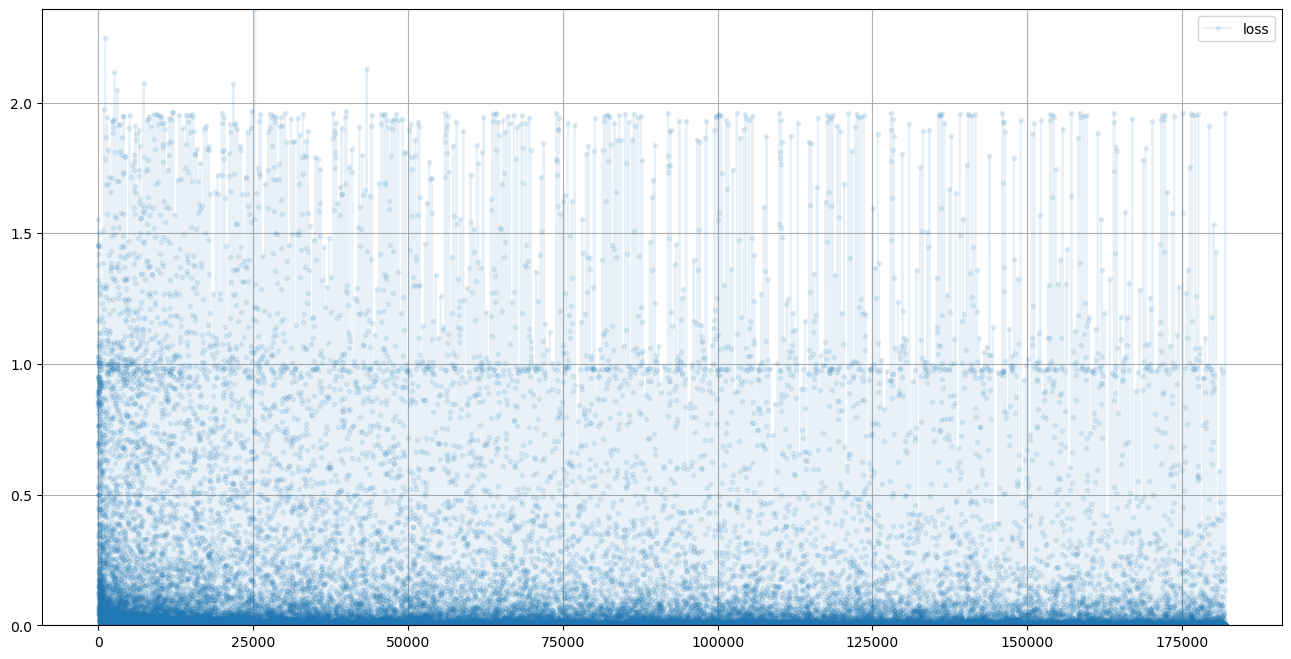

In [11]:
n.plot_progress();

### load the mnist test data CSV file into a list

In [12]:
with open("./mnist_dataset/mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()

### test the neural network

In [13]:
scorecard = []

for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(all_values[0])
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    outputs = n.forward(inputs)
    m, label = outputs.max(1)
    
    # append correct or incorrect to list
    if (label.item() == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)

# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print(f"performance = {scorecard_array.sum()/scorecard_array.size}")

performance = 0.9783

### test backquery

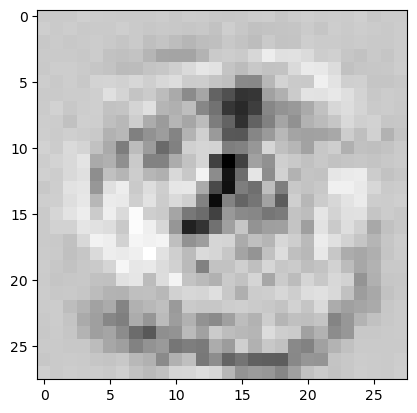

In [14]:
label = 9
targets = np.zeros(output_nodes) + 0.01
targets[label] = 0.99

image_data = n.backquery(targets).cpu().detach().numpy().reshape(28, 28)
plt.imshow(image_data, cmap='Greys', interpolation='None');

In [15]:
n


Classifier(
  (linear_ih): Linear(in_features=784, out_features=200, bias=False)
  (linear_ho): Linear(in_features=200, out_features=10, bias=False)
  (activation): Sigmoid()
  (error_function): MSELoss()
)

In [16]:
n.epochs = 10
n.performance = 0.9811
n.trainging_time = " 23 min 14 s"

n.pickle(f'pytorch_tensor_classifiler_{epochs}.pkl')

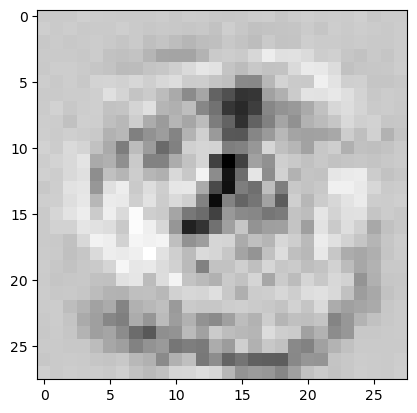

In [19]:
# from pickled object
with open(f'pytorch_tensor_classifiler_{epochs}.pkl', 'rb') as f:
    new_n = pickle.load(f)
    
image_data = new_n.backquery(targets).cpu().detach().numpy().reshape(28, 28)
plt.imshow(image_data, cmap='Greys', interpolation='None');

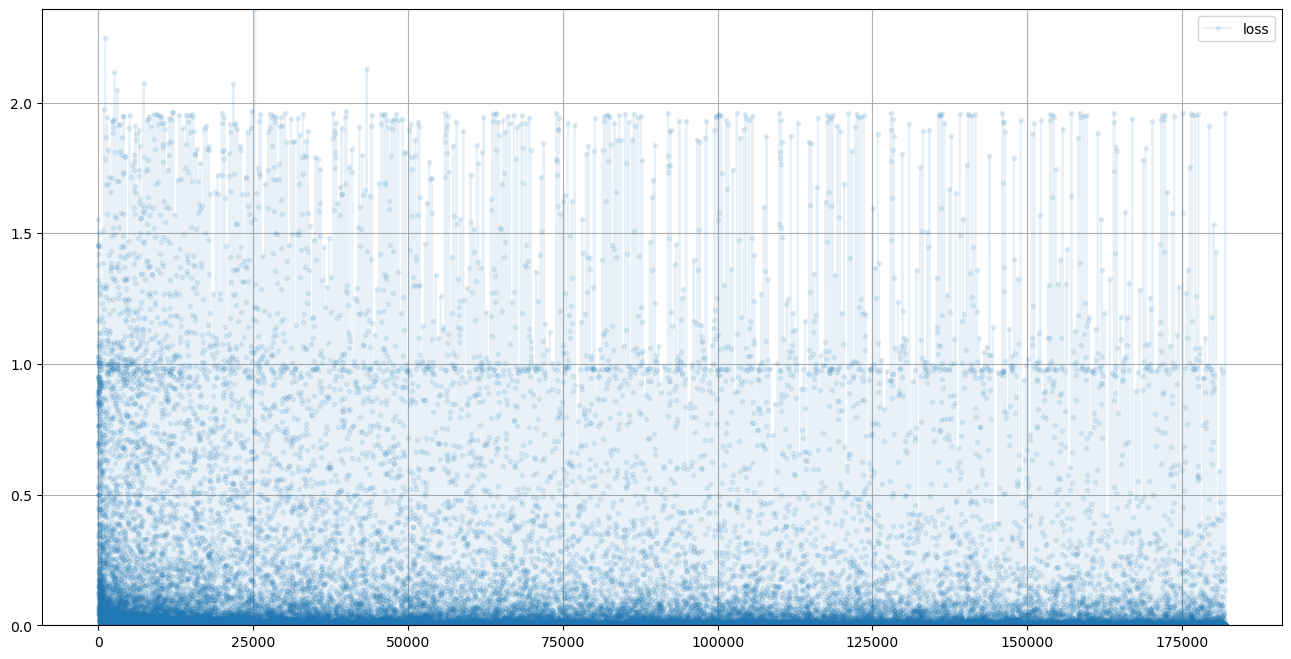

In [20]:
new_n.plot_progress();